In [1]:
import os
os.getcwd()

'/Users/ashkapathak/mstc-ml-woc'

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("data/processed/placement_cleaned.csv")
df.head()

,college_id,iq,prev_sem_result,cgpa,academic_performance,internship_experience,extra_curricular_score,communication_skills,projects_completed,placement
0,CLG0030,107,6.61,6.28,8,No,8,8,4,No
1,CLG0061,97,5.52,5.37,8,No,7,8,0,No
2,CLG0036,109,5.36,5.83,9,No,3,1,1,No
3,CLG0055,122,5.47,5.75,6,Yes,1,6,1,No
4,CLG0004,96,7.91,7.69,7,No,8,10,2,No


In [4]:
print("Shape:", df.shape)
print("\nMissing values per column:\n", df.isna().sum())
print("\nDtypes:\n", df.dtypes)

Shape: (10000, 10)

Missing values per column:
 college_id                0
iq                        0
prev_sem_result           0
cgpa                      0
academic_performance      0
internship_experience     0
extra_curricular_score    0
communication_skills      0
projects_completed        0
placement                 0
dtype: int64

Dtypes:
 college_id                    str
iq                          int64
prev_sem_result           float64
cgpa                      float64
academic_performance        int64
internship_experience         str
extra_curricular_score      int64
communication_skills        int64
projects_completed          int64
placement                     str
dtype: object


In [5]:
df.columns

Index(['college_id', 'iq', 'prev_sem_result', 'cgpa', 'academic_performance',
       'internship_experience', 'extra_curricular_score',
       'communication_skills', 'projects_completed', 'placement'],
      dtype='str')

In [6]:
target_col = "placement"
X = df.drop(columns=[target_col])
y = df[target_col]
y.value_counts()

placement
No     8341
Yes    1659
Name: count, dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'No': np.int64(0), 'Yes': np.int64(1)}

In [9]:
cat_cols = X.select_dtypes(include=["object", "string"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object", "string"]).columns.tolist()
print("Categorical:", cat_cols)
print("Numerical:", num_cols)

Categorical: ['college_id', 'internship_experience']
Numerical: ['iq', 'prev_sem_result', 'cgpa', 'academic_performance', 'extra_curricular_score', 'communication_skills', 'projects_completed']


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)
print(X_train.shape, X_test.shape)

(8000, 9) (2000, 9)


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

In [12]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="logloss"
)
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", xgb)
])
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred = model.predict(X_test)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1       :", f1_score(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred))

Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1       : 1.0

Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1668
           1       1.00      1.00      1.00       332

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



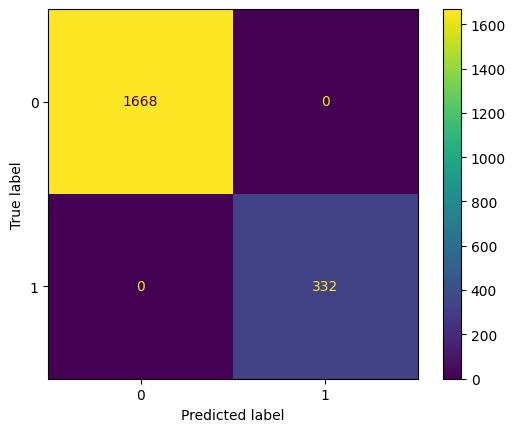

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [15]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
scale_pos_weight

np.float64(5.028636021100226)

In [16]:
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", xgb)
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("F1:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

F1: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1668
           1       1.00      1.00      1.00       332

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__n_estimators": [150, 250],
    "classifier__max_depth": [3, 5],
    "classifier__learning_rate": [0.05, 0.1],
}
grid = GridSearchCV(
    model,
    param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)
best_model = grid.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 150}
Best CV F1: 0.9984934067393235


In [18]:
import joblib, os

os.makedirs("models", exist_ok=True)

joblib.dump(best_model, "models/xgboost_pipeline.pkl")
joblib.dump(label_encoder, "models/label_encoder.pkl")
print("Saved!")

Saved!


In [19]:
loaded = joblib.load("models/xgboost_pipeline.pkl")
loaded.predict(X_test.iloc[:3])

array([0, 0, 0])

The model performs very well across all evaluation metrics, which suggests the dataset is relatively easy to separate due to strong features such as CGPA, academic performance, and internship experience. It feels like the test set we set aside the results. This problem arises from a super clean dataset or from features that really capture what drives placement outcomes. While it shows that our preprocessing and modelling steps are solid, we definitely need to test them on some real-world or messier data to see how well they actually generalise.

In [20]:
X.drop(columns=["cgpa", "academic_performance"]).head()

,college_id,iq,prev_sem_result,internship_experience,extra_curricular_score,communication_skills,projects_completed
0,CLG0030,107,6.61,No,8,8,4
1,CLG0061,97,5.52,No,7,8,0
2,CLG0036,109,5.36,No,3,1,1
3,CLG0055,122,5.47,Yes,1,6,1
4,CLG0004,96,7.91,No,8,10,2


Even after removing strong academic indicators, the dataset structure suggests high separability.